##**Introduction**

With humble beginning that trace to late 19th century Japan, Anime has become global phenomenon captivating audiences.  As the number of titles grows, discovering new titles can be overwhelming.  This is where an anime recommender system can be beneficial.  

Our aim is to design a system to enhance the user’s experience by suggesting relevant shows and movies based on their taste and behavior patterns.  By analyzing viewer history, ratings, and behavior, we can identify patterns and similarities that could lead users to new titles. 

In this project, we focus on  building a content-based recommendation system. This system generates suggestions based on content that another user has previously enjoyed.  By using cosine similarity, we can compare features and identify those that match a user's interest and taste.  The goal is to create a way for users to discover new anime.  To evaluate the success of our recommendation system, we will test it out with members of our team and classmates.


##**What is a Recommendation System?**

A recommendation system is an algorithm designed to suggest relevant products to a user based on the user’s behaviors, similarities with another user, and interests.  Products can include books, music, videos, customer satisfaction, etc.   


##**How does it work?**

It begins with access to user data. Next, a content-based matrix is created based on the viewed anime titles and their ratings. A weighted feature matrix is computed using the user's matrix and the matrix containing all titles. This weighted features matrix is calculated using a similarity algorithm like cosine similarity, which determines how similar two vectors are to one another. The formula is as follows:

Cosine Similarity Formula:



$Cosine Similarity}(x,y) = \frac{x \cdot y}{||x|| \cdot ||y||}$


where:
- $ x \cdot y$ is the dot product of vectors $x$ and $y$,
- $||x||$ is the magnitude (norm) of vector $x$,
- $(||y||\)$ is the magnitude (norm) of vector $y$.


It measures the cosine of the angle between the vectors and produces a value between -1 and 1. A value of 1 suggests that 𝑥 and 𝑦 are very similar in tastes. A value of 0 suggests that 𝑥 and 𝑦 don’t share any interests, while a value of -1 suggests that 𝑥 and 𝑦 have opposite interests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


C:\Users\mattb\anaconda3\envs\recommender\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rating_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv')

In [3]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
rating_df.shape

(7813737, 3)

In [5]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [6]:
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
anime_df.shape

(12294, 7)

In [9]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [10]:
anime_df = anime_df.dropna()

In [11]:
genre_split = anime_df['genre'].str.split(',', expand=True)

anime_df['genre_1'] = genre_split[0].str.strip().str.lower()
anime_df['genre_2'] = genre_split[1].str.strip().str.lower()
anime_df['genre_3'] = genre_split[2].str.strip().str.lower()

In [12]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,drama,romance,school
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,action,adventure,drama
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,action,comedy,historical
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,sci-fi,thriller,None
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,action,comedy,historical


In [13]:
anime_df['genre_1'].unique()

array(['drama', 'action', 'sci-fi', 'comedy', 'adventure', 'fantasy',
       'mystery', 'psychological', 'ecchi', 'josei', 'military',
       'romance', 'demons', 'dementia', 'music', 'game', 'cars', 'mecha',
       'horror', 'school', 'historical', 'kids', 'shounen', 'shoujo',
       'magic', 'harem', 'martial arts', 'sports', 'slice of life',
       'seinen', 'parody', 'police', 'thriller', 'supernatural',
       'samurai', 'super power', 'vampire', 'space', 'hentai', 'yaoi'],
      dtype=object)

In [14]:
anime_df['genre_2'].unique()

array(['romance', 'adventure', 'comedy', 'thriller', 'drama', 'military',
       'fantasy', 'school', 'music', 'slice of life', 'mecha', 'mystery',
       'horror', 'police', 'parody', 'seinen', 'psychological', 'sci-fi',
       'demons', 'historical', 'sports', 'supernatural', 'game', 'magic',
       'josei', 'shounen', 'harem', 'cars', 'dementia', None, 'shoujo',
       'kids', 'samurai', 'ecchi', 'shoujo ai', 'super power',
       'martial arts', 'shounen ai', 'space', 'vampire', 'hentai', 'yaoi',
       'yuri'], dtype=object)

In [15]:
anime_df['genre_3'].unique()

array(['school', 'drama', 'historical', None, 'shounen', 'sci-fi',
       'romance', 'mecha', 'supernatural', 'military', 'comedy', 'parody',
       'fantasy', 'shoujo', 'mystery', 'psychological', 'sports',
       'seinen', 'horror', 'josei', 'slice of life', 'music',
       'shounen ai', 'ecchi', 'demons', 'magic', 'vampire', 'police',
       'martial arts', 'space', 'super power', 'dementia', 'shoujo ai',
       'thriller', 'harem', 'kids', 'samurai', 'game', 'cars', 'yaoi',
       'hentai', 'yuri'], dtype=object)

In [16]:
anime_df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [17]:
df = anime_df
anime_df.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [18]:
def removeOutliers(df, column, lower_quartile=0.25, upper_quartile=0.75, multiplier=1.5, direction='both'):
    """
    Removes outliers from a DataFrame based on the IQR method for a specified column.
    
    Parameters:
    - df (DataFrame): The DataFrame to process.
    - column (str): The column to assess for outliers.
    - lower_quartile (float): The lower quartile (default: 0.25).
    - upper_quartile (float): The upper quartile (default: 0.75).
    - multiplier (float): The multiplier for the IQR (default: 1.5).
    - direction (str): 'both', 'low', or 'high' to specify which outliers to remove.
    
    Returns:
    - DataFrame: A new DataFrame with outliers removed.
    """
    # Calculate the quartiles and IQR
    Q1 = df[column].quantile(lower_quartile)
    Q3 = df[column].quantile(upper_quartile)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    
    # Filter based on direction
    if direction == 'low':
        return df[df[column] >= lower_bound]
    elif direction == 'high':
        return df[df[column] <= upper_bound]
    else:
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [19]:
anime_df = removeOutliers(anime_df, column='members', direction='low')

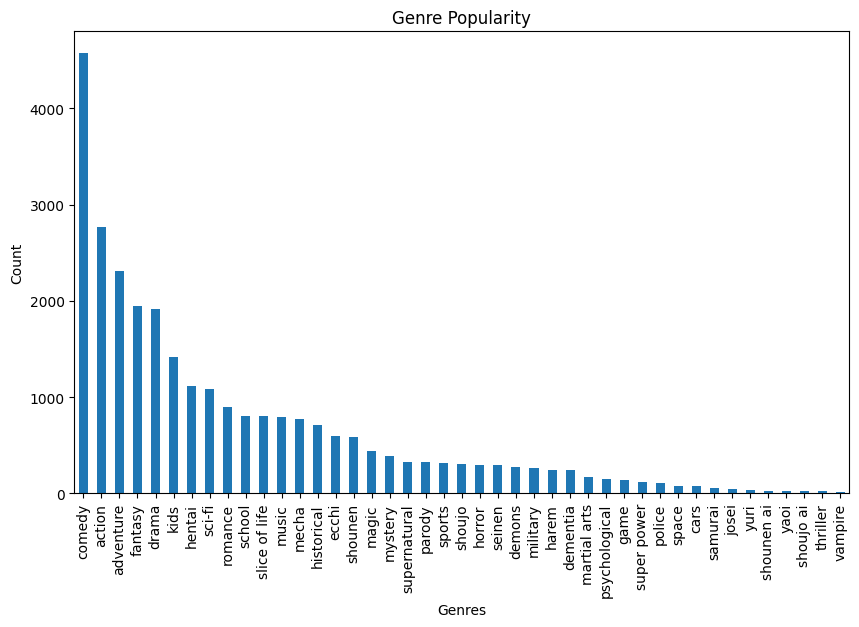

In [20]:
genres = pd.concat([df['genre_1'], df['genre_2'], df['genre_3']]).dropna()
genre_counts = genres.value_counts()

genre_counts.plot(kind='bar', figsize=(10, 6), title='Genre Popularity')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

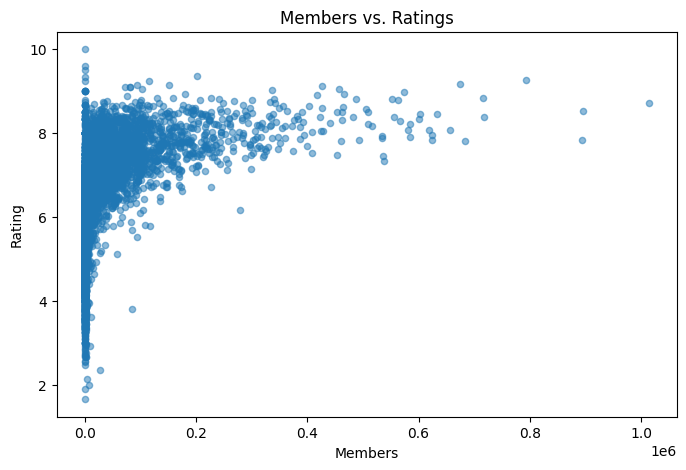

In [21]:
# Scatter plot
anime_df.plot.scatter(x='members', y='rating', alpha=0.5, figsize=(8, 5), title='Members vs. Ratings')
plt.xlabel('Members')
plt.ylabel('Rating')
plt.show()

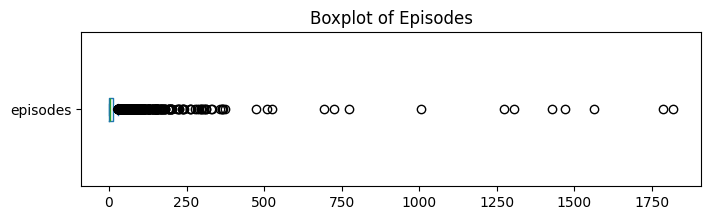

In [22]:
# Boxplot
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'].plot(kind='box', vert=False, figsize=(8, 2), title='Boxplot of Episodes')
plt.show()

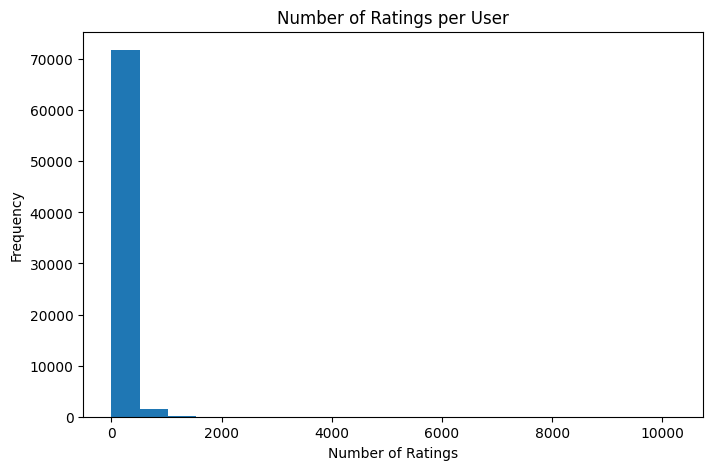

In [23]:
# Ratings per user
user_ratings = rating_df.groupby('user_id')['anime_id'].count()
user_ratings.plot(kind='hist', bins=20, figsize=(8, 5), title='Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

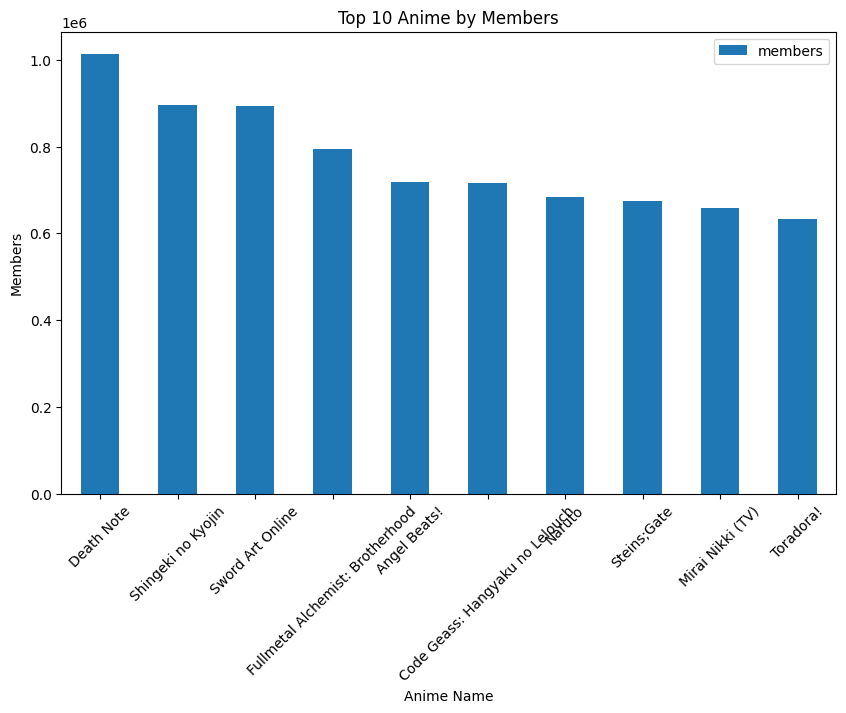

In [24]:
# Top 10 most popular anime by members
top_anime = df[['name', 'members']].drop_duplicates().sort_values(by='members', ascending=False).head(10)
top_anime.plot(x='name', y='members', kind='bar', figsize=(10, 6), title='Top 10 Anime by Members')
plt.xlabel('Anime Name')
plt.ylabel('Members')
plt.xticks(rotation=45)
plt.show()

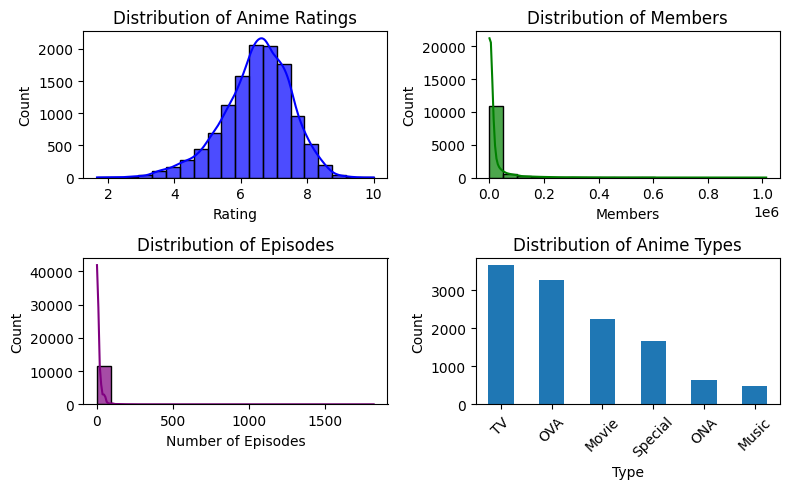

In [25]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Histogram and KDE for Episodes Distribution
sns.histplot(df['episodes'].dropna(), bins=20, kde=True, ax=axes[1, 0], color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes')
axes[1, 0].set_xlabel('Number of Episodes')
axes[1, 0].set_ylabel('Count')

# Bar Chart for Type Distribution (no KDE)
type_counts = df['type'].value_counts()
type_counts.plot(kind='bar', figsize=(8, 5), title='Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


In [26]:
def categorize_content(row):
    if   row['episodes'] == 1: return 'Movie/Short Film'
    elif row['episodes'] <= 12: return '<=12 Episodes'
    elif row['episodes'] <= 24: return '<=24 Episodes'
    else: return '>24 Episodes'

df['episodes_categorical'] = df.apply(categorize_content, axis=1)

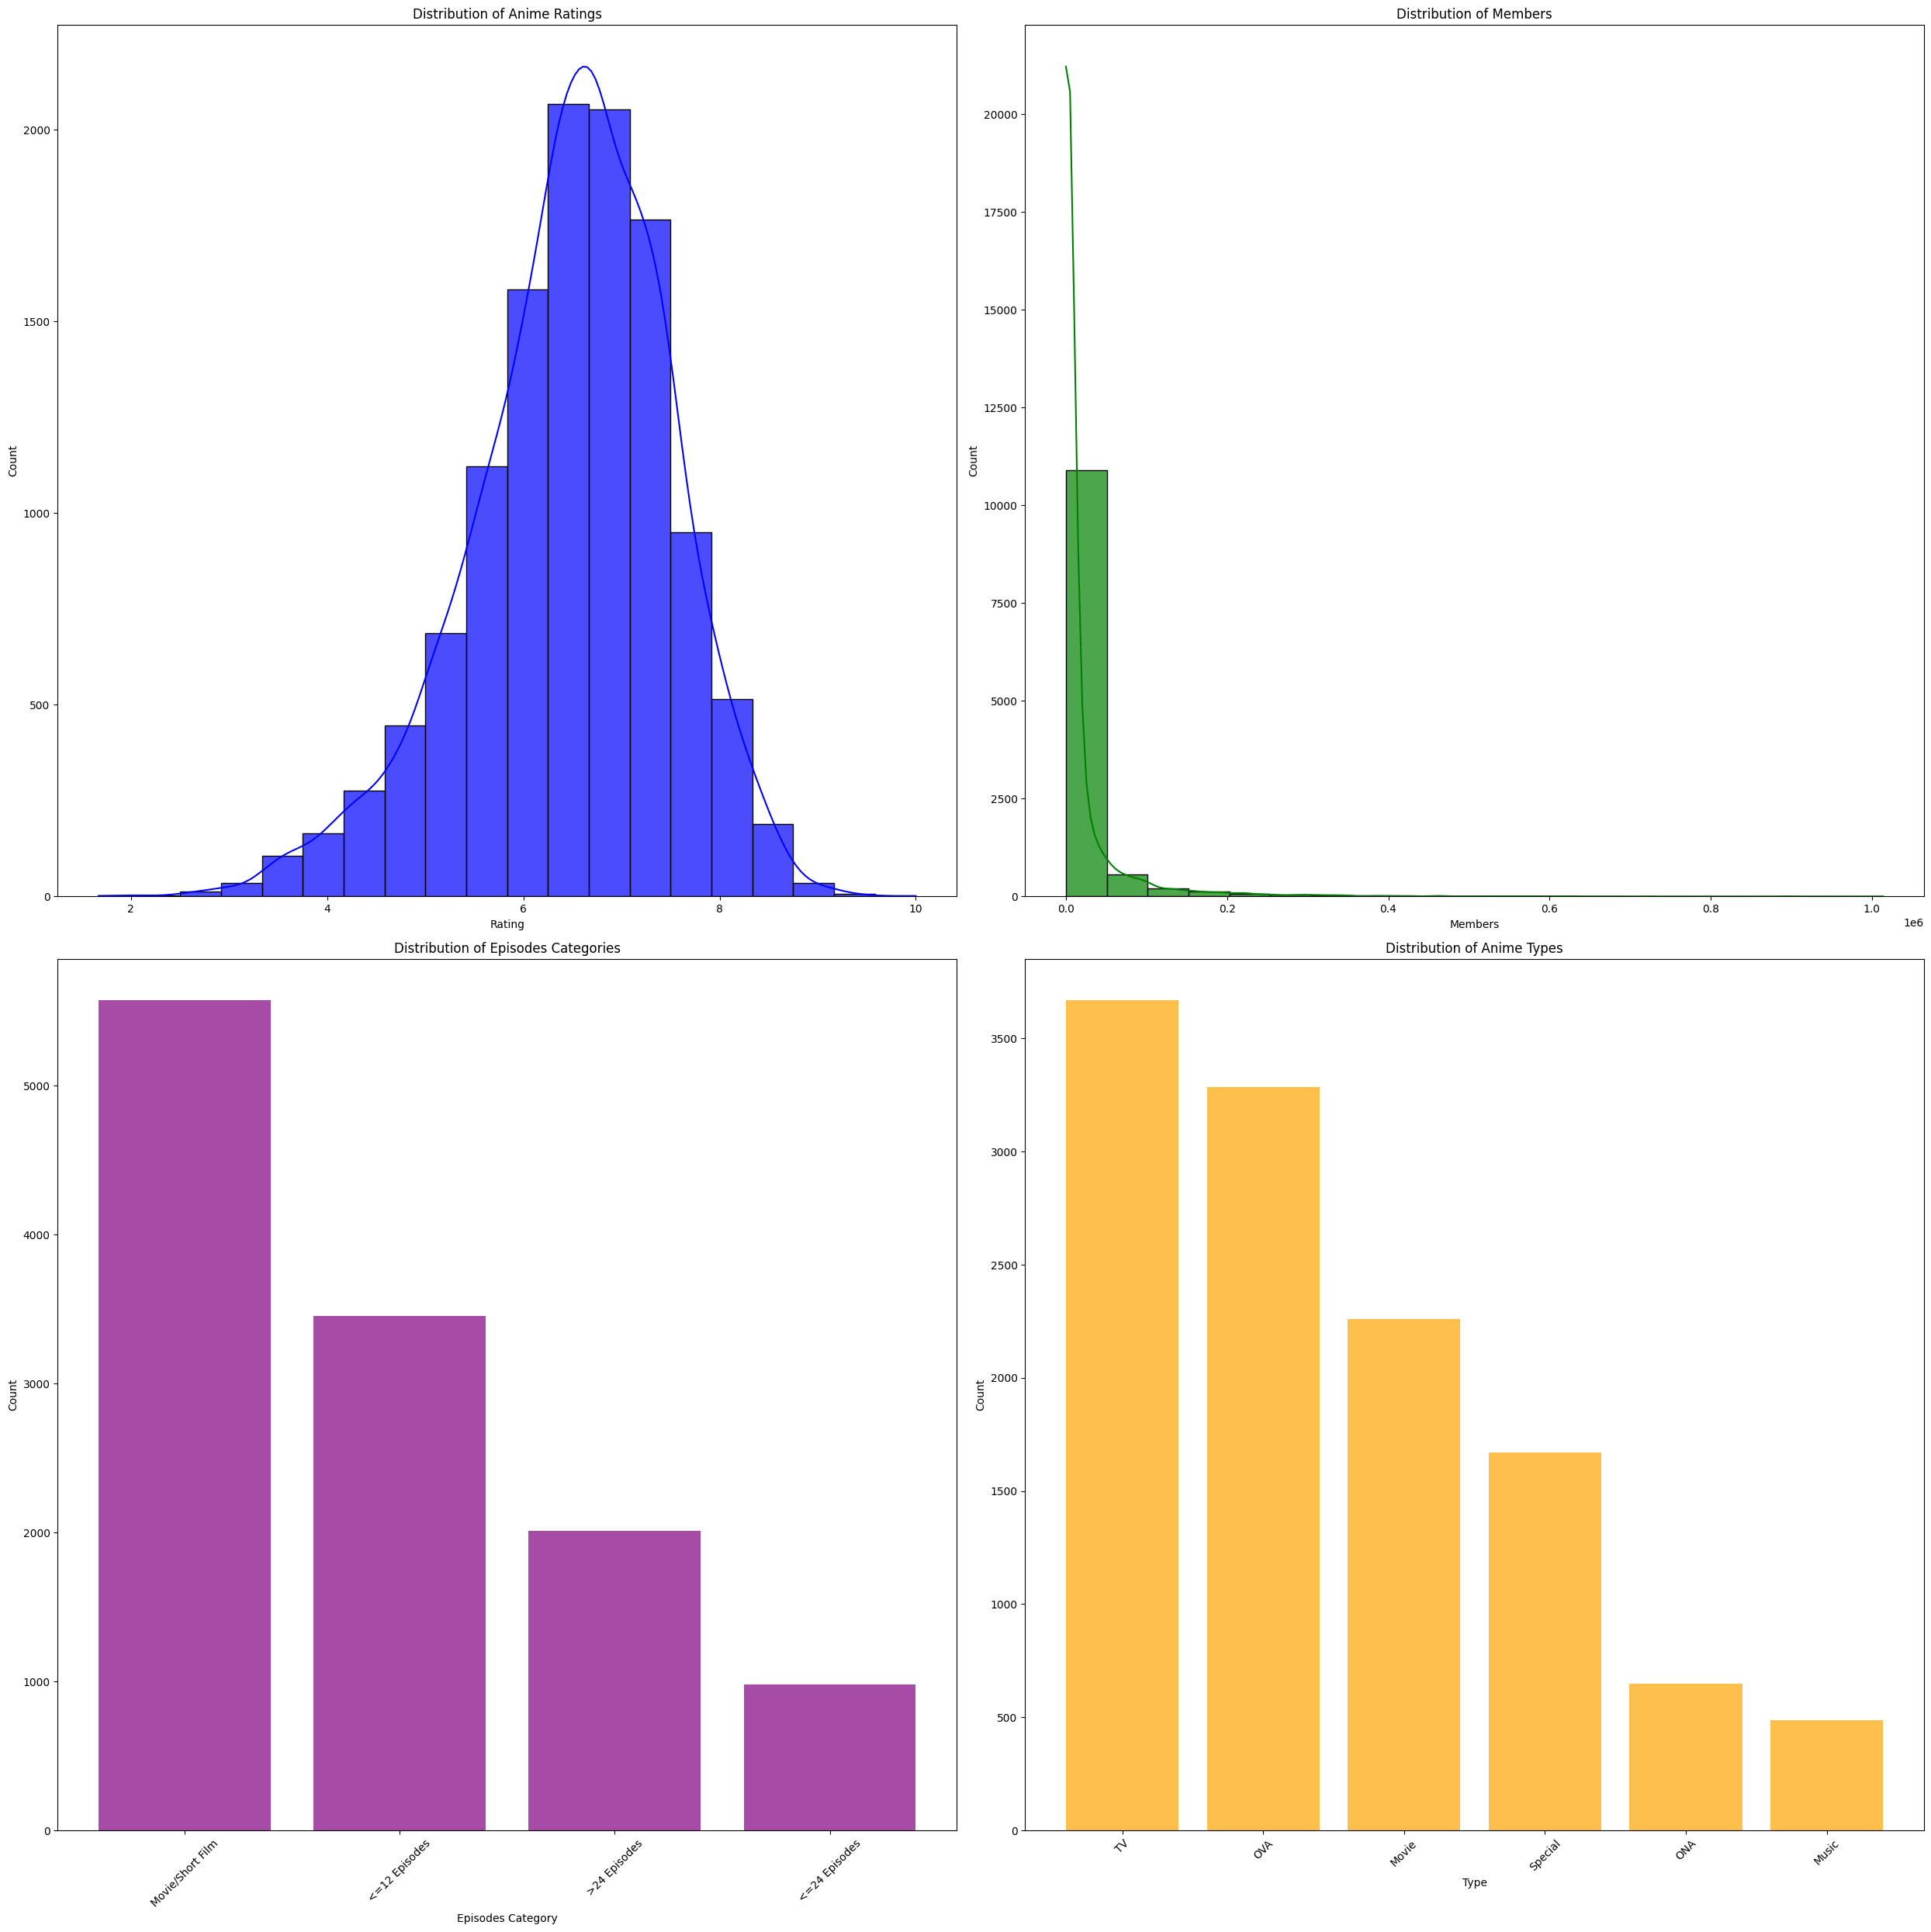

In [27]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(25, 25))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Bar Chart for Episodes Categorical Distribution
episodes_counts = df['episodes_categorical'].value_counts()
axes[1, 0].bar(episodes_counts.index, episodes_counts.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes Categories')
axes[1, 0].set_xlabel('Episodes Category')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Bar Chart for Type Distribution
type_counts = df['type'].value_counts()
axes[1, 1].bar(type_counts.index, type_counts.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [28]:
df['type'].value_counts()

type
TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
Name: count, dtype: int64

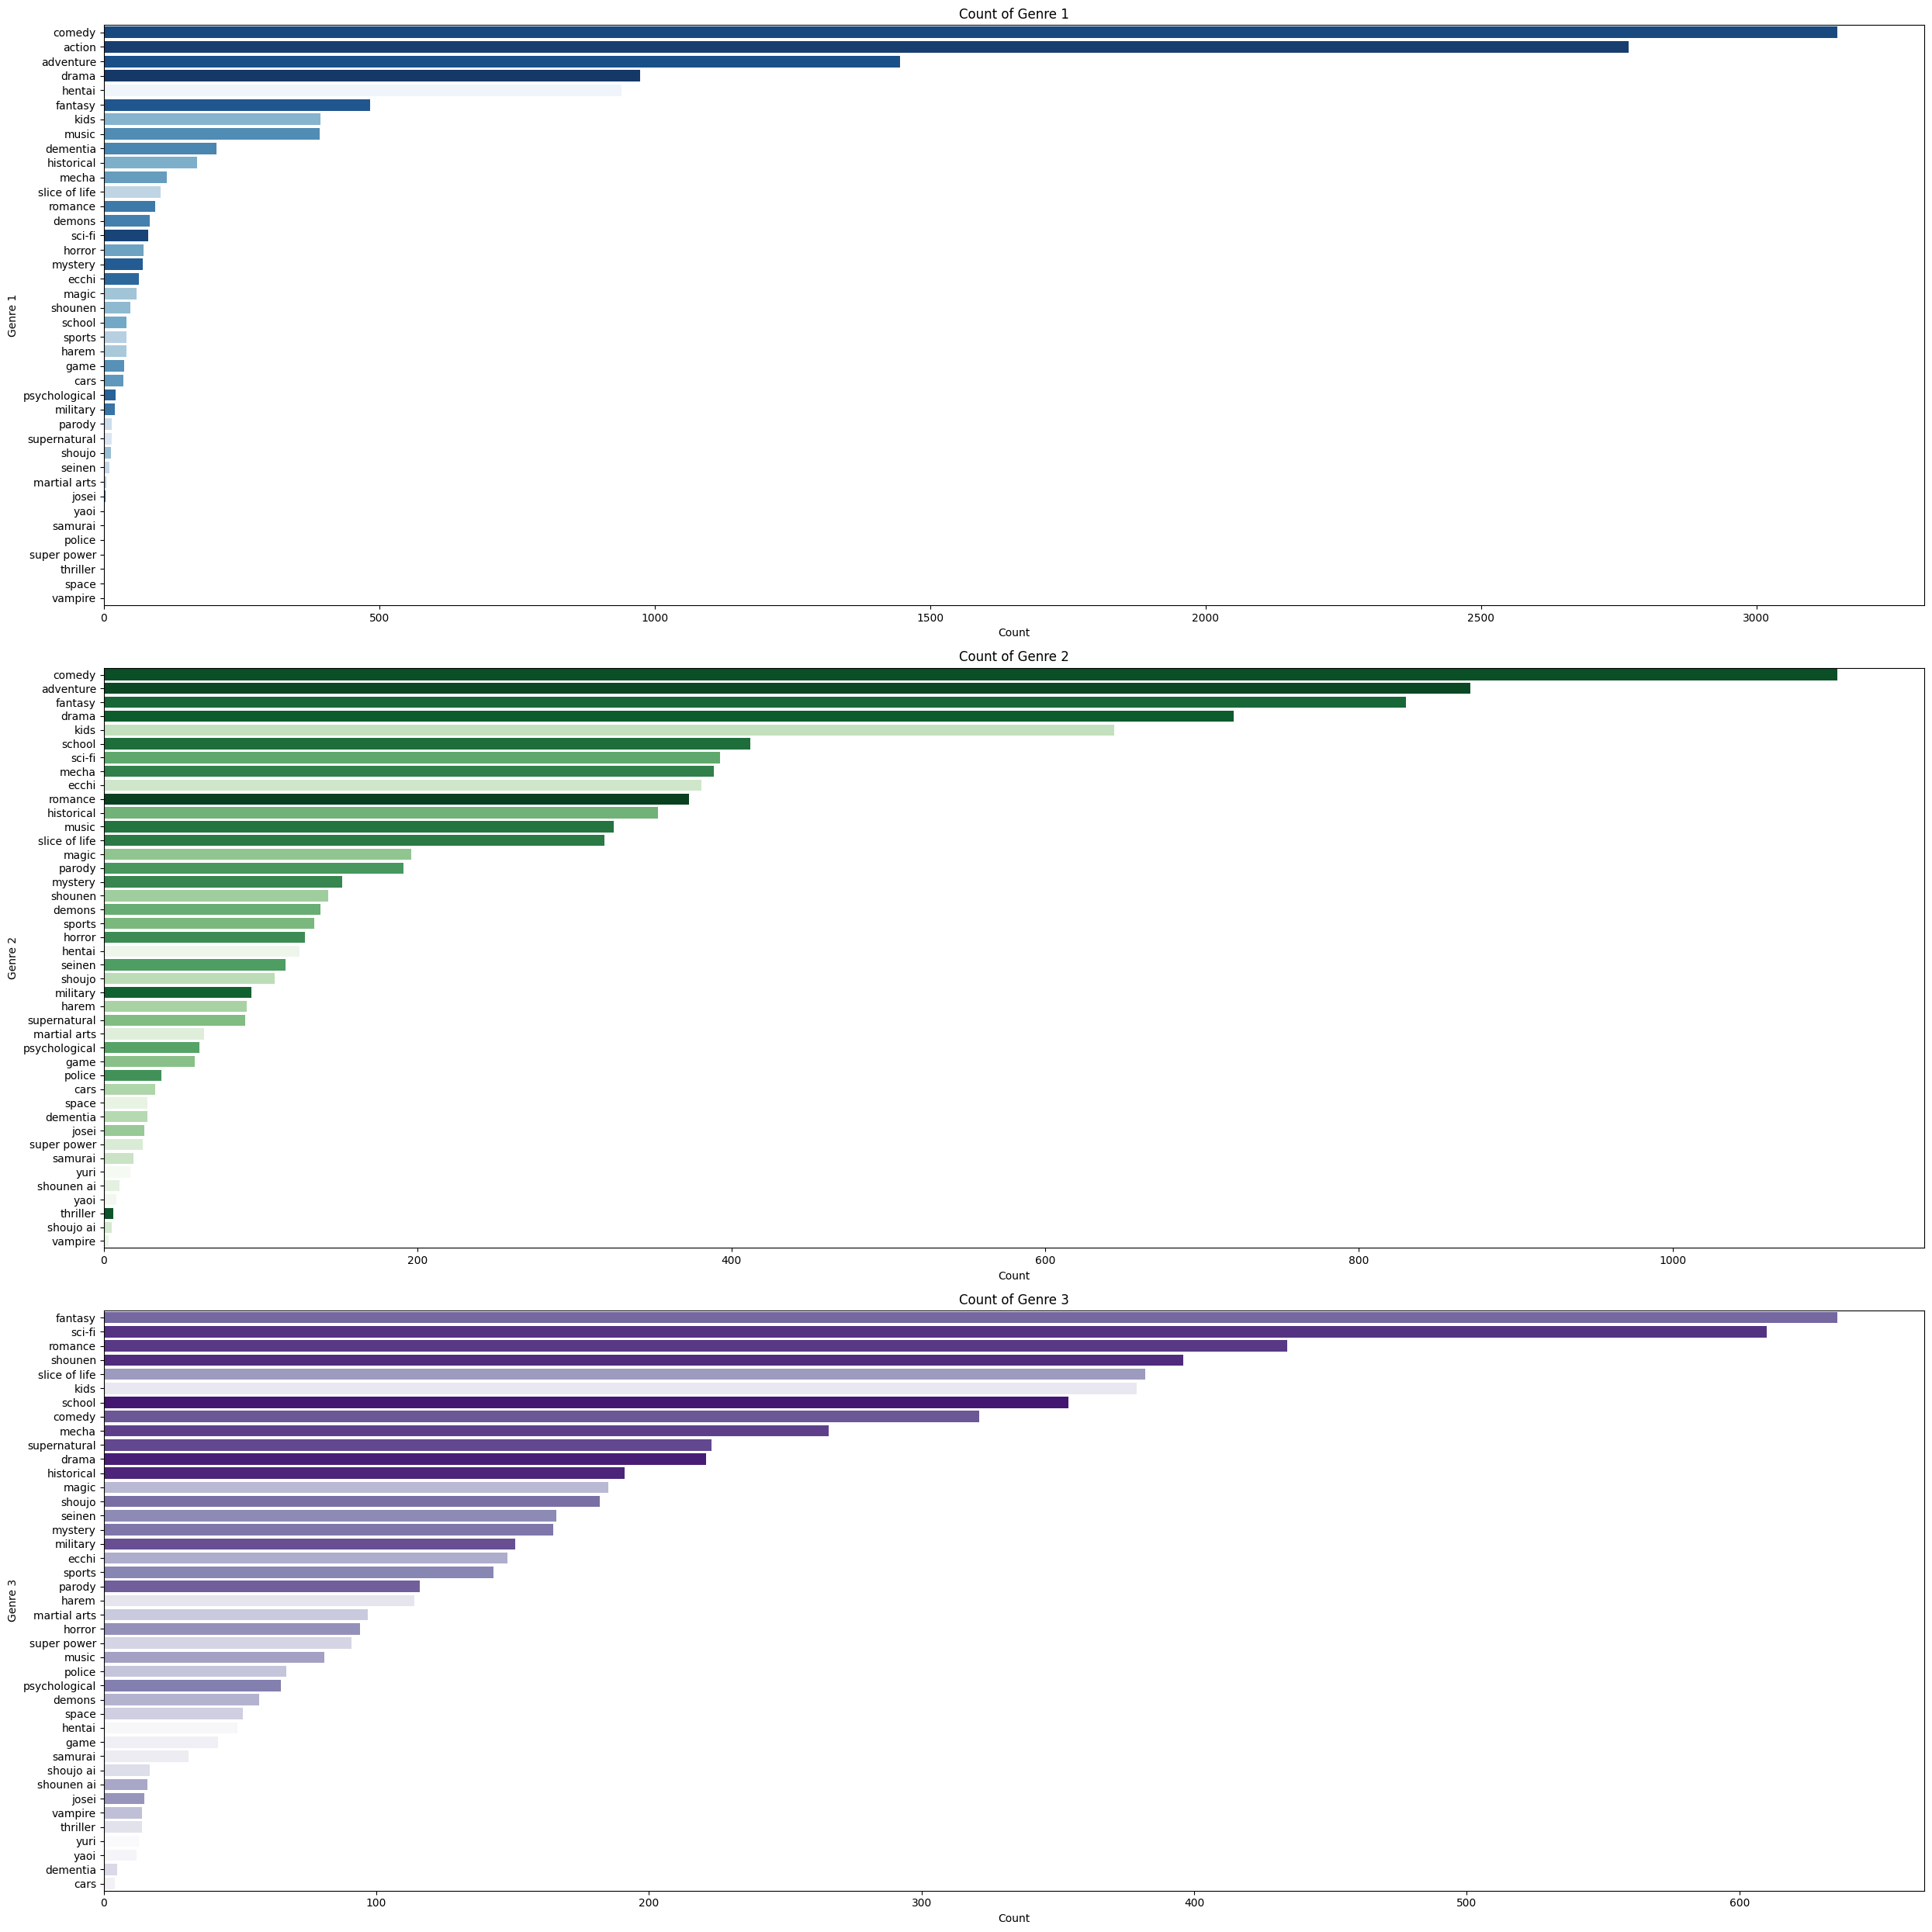

In [29]:
# Set up a figure with subplots (1 plot per row)
fig, axes = plt.subplots(3, 1, figsize=(25, 25))  # 3 rows, 1 column

# Countplot for genre_1
sns.countplot(data=df, y='genre_1', ax=axes[0], order=df['genre_1'].value_counts().index, palette='Blues_r', hue=df['genre_1'], legend=False)
axes[0].set_title('Count of Genre 1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre 1')

# Countplot for genre_2
sns.countplot(data=df, y='genre_2', ax=axes[1], order=df['genre_2'].value_counts().index, palette='Greens_r', hue=df['genre_2'], legend=False)
axes[1].set_title('Count of Genre 2')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Genre 2')

# Countplot for genre_3
sns.countplot(data=df, y='genre_3', ax=axes[2], order=df['genre_3'].value_counts().index, palette='Purples_r', hue=df['genre_3'], legend=False)
axes[2].set_title('Count of Genre 3')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Genre 3')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


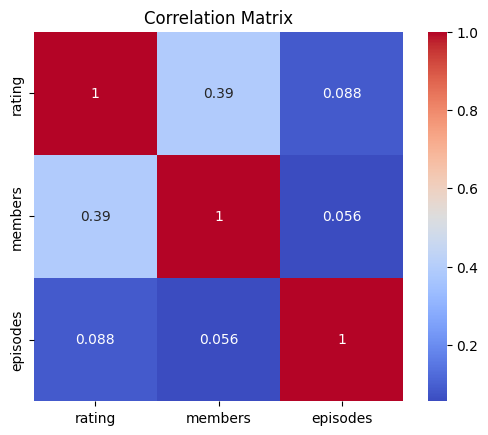

In [30]:
correlation_matrix = df[['rating', 'members', 'episodes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [31]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3,episodes_categorical
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,drama,romance,school,Movie/Short Film
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,action,adventure,drama,>24 Episodes
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,action,comedy,historical,>24 Episodes
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,sci-fi,thriller,None,<=24 Episodes
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,action,comedy,historical,>24 Episodes


In [32]:
for x in df.columns: print(x)

anime_id
name
genre
type
episodes
rating
members
genre_1
genre_2
genre_3
episodes_categorical


In [33]:
# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[['type', 'genre_1', 'genre_2', 'genre_3']])

# Create a DataFrame for the encoded features
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

# Define the mapping
ordinal_mapping = {
    'Movie/Short Film': 0,
    '<=12 Episodes': 1,
    '<=24 Episodes': 2,
    '>24 Episodes': 4
}

# Apply the mapping
df['episodes_categorical'] = df['episodes_categorical'].map(ordinal_mapping)
df = pd.concat([df, one_hot_df], axis=1)


In [34]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

In [35]:
scaler = MinMaxScaler()
df[['episodes', 'rating', 'members']] = scaler.fit_transform(df[['episodes', 'rating', 'members']])

In [36]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3,episodes_categorical,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre_1_action,genre_1_adventure,genre_1_cars,genre_1_comedy,genre_1_dementia,genre_1_demons,genre_1_drama,genre_1_ecchi,genre_1_fantasy,genre_1_game,genre_1_harem,genre_1_hentai,genre_1_historical,genre_1_horror,genre_1_josei,genre_1_kids,genre_1_magic,genre_1_martial arts,genre_1_mecha,genre_1_military,genre_1_music,genre_1_mystery,genre_1_parody,genre_1_police,genre_1_psychological,genre_1_romance,genre_1_samurai,genre_1_school,genre_1_sci-fi,genre_1_seinen,genre_1_shoujo,genre_1_shounen,genre_1_slice of life,genre_1_space,genre_1_sports,genre_1_super power,genre_1_supernatural,genre_1_thriller,genre_1_vampire,genre_1_yaoi,genre_2_adventure,genre_2_cars,genre_2_comedy,genre_2_dementia,genre_2_demons,genre_2_drama,genre_2_ecchi,genre_2_fantasy,genre_2_game,genre_2_harem,genre_2_hentai,genre_2_historical,genre_2_horror,genre_2_josei,genre_2_kids,genre_2_magic,genre_2_martial arts,genre_2_mecha,genre_2_military,genre_2_music,genre_2_mystery,genre_2_parody,genre_2_police,genre_2_psychological,genre_2_romance,genre_2_samurai,genre_2_school,genre_2_sci-fi,genre_2_seinen,genre_2_shoujo,genre_2_shoujo ai,genre_2_shounen,genre_2_shounen ai,genre_2_slice of life,genre_2_space,genre_2_sports,genre_2_super power,genre_2_supernatural,genre_2_thriller,genre_2_vampire,genre_2_yaoi,genre_2_yuri,genre_2_None,genre_3_cars,genre_3_comedy,genre_3_dementia,genre_3_demons,genre_3_drama,genre_3_ecchi,genre_3_fantasy,genre_3_game,genre_3_harem,genre_3_hentai,genre_3_historical,genre_3_horror,genre_3_josei,genre_3_kids,genre_3_magic,genre_3_martial arts,genre_3_mecha,genre_3_military,genre_3_music,genre_3_mystery,genre_3_parody,genre_3_police,genre_3_psychological,genre_3_romance,genre_3_samurai,genre_3_school,genre_3_sci-fi,genre_3_seinen,genre_3_shoujo,genre_3_shoujo ai,genre_3_shounen,genre_3_shounen ai,genre_3_slice of life,genre_3_space,genre_3_sports,genre_3_super power,genre_3_supernatural,genre_3_thriller,genre_3_vampire,genre_3_yaoi,genre_3_yuri,genre_3_None
0,32281.0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,0.000000,0.924370,0.197867,drama,romance,school,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114.0,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,0.034673,0.911164,0.782769,action,adventure,drama,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28977.0,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,0.027518,0.909964,0.112683,action,comedy,historical,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

In [38]:
features = [
    "anime_id", "name", "rating", "members", "episodes_categorical", 
    "type_Movie", "type_Music", "type_ONA", "type_OVA", "type_Special", "type_TV",
    
    "genre_1_action",    "genre_1_adventure",    "genre_1_cars",    "genre_1_comedy",    "genre_1_dementia",    "genre_1_demons",    "genre_1_drama",
    "genre_1_ecchi",    "genre_1_fantasy",    "genre_1_game",    "genre_1_harem",    "genre_1_hentai",    "genre_1_historical",    "genre_1_horror",
    "genre_1_josei",    "genre_1_kids",    "genre_1_magic",    "genre_1_martial arts",    "genre_1_mecha",    "genre_1_military",    "genre_1_music",
    "genre_1_mystery",    "genre_1_parody",    "genre_1_police",    "genre_1_psychological",    "genre_1_romance",    "genre_1_samurai",    "genre_1_school",
    "genre_1_sci-fi",    "genre_1_seinen",    "genre_1_shoujo",    "genre_1_shounen",    "genre_1_slice of life",    "genre_1_space",    "genre_1_sports",
    "genre_1_super power",    "genre_1_supernatural",    "genre_1_thriller",    "genre_1_vampire",    "genre_1_yaoi",
    
    "genre_2_adventure",    "genre_2_cars",    "genre_2_comedy",    "genre_2_dementia",    "genre_2_demons",    "genre_2_drama",    "genre_2_ecchi",
    "genre_2_fantasy",    "genre_2_game",    "genre_2_harem",    "genre_2_hentai",    "genre_2_historical",    "genre_2_horror",    "genre_2_josei",
    "genre_2_kids",    "genre_2_magic",    "genre_2_martial arts",    "genre_2_mecha",    "genre_2_military",    "genre_2_music",    "genre_2_mystery",
    "genre_2_parody",    "genre_2_police",    "genre_2_psychological",    "genre_2_romance",    "genre_2_samurai",    "genre_2_school",    "genre_2_sci-fi",
    "genre_2_seinen",    "genre_2_shoujo",    "genre_2_shoujo ai",    "genre_2_shounen",    "genre_2_shounen ai",    "genre_2_slice of life",
    "genre_2_space",    "genre_2_sports",    "genre_2_super power",    "genre_2_supernatural",    "genre_2_thriller",    "genre_2_vampire",
    "genre_2_yaoi",    "genre_2_yuri",
    
    "genre_3_cars",    "genre_3_comedy",    "genre_3_dementia",    "genre_3_demons",    "genre_3_drama",    "genre_3_ecchi",    "genre_3_fantasy",
    "genre_3_game",    "genre_3_harem",    "genre_3_hentai",    "genre_3_historical",    "genre_3_horror",    "genre_3_josei",    "genre_3_kids",
    "genre_3_magic",    "genre_3_martial arts",    "genre_3_mecha",    "genre_3_military",    "genre_3_music",    "genre_3_mystery",    "genre_3_parody",
    "genre_3_police",    "genre_3_psychological",    "genre_3_romance",    "genre_3_samurai",    "genre_3_school",    "genre_3_sci-fi",    "genre_3_seinen",
    "genre_3_shoujo",    "genre_3_shoujo ai",    "genre_3_shounen",    "genre_3_shounen ai",    "genre_3_slice of life",    "genre_3_space",
    "genre_3_sports",    "genre_3_super power",    "genre_3_supernatural",    "genre_3_thriller",    "genre_3_vampire",    "genre_3_yaoi",    "genre_3_yuri",
]

df = df[features]


In [39]:
df.head()

,anime_id,name,rating,members,episodes_categorical,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre_1_action,genre_1_adventure,genre_1_cars,genre_1_comedy,genre_1_dementia,genre_1_demons,genre_1_drama,genre_1_ecchi,genre_1_fantasy,genre_1_game,genre_1_harem,genre_1_hentai,genre_1_historical,genre_1_horror,genre_1_josei,genre_1_kids,genre_1_magic,genre_1_martial arts,genre_1_mecha,genre_1_military,genre_1_music,genre_1_mystery,genre_1_parody,genre_1_police,genre_1_psychological,genre_1_romance,genre_1_samurai,genre_1_school,genre_1_sci-fi,genre_1_seinen,genre_1_shoujo,genre_1_shounen,genre_1_slice of life,genre_1_space,genre_1_sports,genre_1_super power,genre_1_supernatural,genre_1_thriller,genre_1_vampire,genre_1_yaoi,genre_2_adventure,genre_2_cars,genre_2_comedy,genre_2_dementia,genre_2_demons,genre_2_drama,genre_2_ecchi,genre_2_fantasy,genre_2_game,genre_2_harem,genre_2_hentai,genre_2_historical,genre_2_horror,genre_2_josei,genre_2_kids,genre_2_magic,genre_2_martial arts,genre_2_mecha,genre_2_military,genre_2_music,genre_2_mystery,genre_2_parody,genre_2_police,genre_2_psychological,genre_2_romance,genre_2_samurai,genre_2_school,genre_2_sci-fi,genre_2_seinen,genre_2_shoujo,genre_2_shoujo ai,genre_2_shounen,genre_2_shounen ai,genre_2_slice of life,genre_2_space,genre_2_sports,genre_2_super power,genre_2_supernatural,genre_2_thriller,genre_2_vampire,genre_2_yaoi,genre_2_yuri,genre_3_cars,genre_3_comedy,genre_3_dementia,genre_3_demons,genre_3_drama,genre_3_ecchi,genre_3_fantasy,genre_3_game,genre_3_harem,genre_3_hentai,genre_3_historical,genre_3_horror,genre_3_josei,genre_3_kids,genre_3_magic,genre_3_martial arts,genre_3_mecha,genre_3_military,genre_3_music,genre_3_mystery,genre_3_parody,genre_3_police,genre_3_psychological,genre_3_romance,genre_3_samurai,genre_3_school,genre_3_sci-fi,genre_3_seinen,genre_3_shoujo,genre_3_shoujo ai,genre_3_shounen,genre_3_shounen ai,genre_3_slice of life,genre_3_space,genre_3_sports,genre_3_super power,genre_3_supernatural,genre_3_thriller,genre_3_vampire,genre_3_yaoi,genre_3_yuri
0,32281.0,Kimi no Na wa.,0.924370,0.197867,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114.0,Fullmetal Alchemist: Brotherhood,0.911164,0.782769,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28977.0,Gintama°,0.909964,0.112683,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9253.0,Steins;Gate,0.900360,0.664323,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [40]:
df.shape

(12284, 134)

In [41]:
df.isna().sum()

anime_id                 267
name                     267
rating                   267
members                  267
episodes_categorical     267
type_Movie               267
type_Music               267
type_ONA                 267
type_OVA                 267
type_Special             267
type_TV                  267
genre_1_action           267
genre_1_adventure        267
genre_1_cars             267
genre_1_comedy           267
genre_1_dementia         267
genre_1_demons           267
genre_1_drama            267
genre_1_ecchi            267
genre_1_fantasy          267
genre_1_game             267
genre_1_harem            267
genre_1_hentai           267
genre_1_historical       267
genre_1_horror           267
genre_1_josei            267
genre_1_kids             267
genre_1_magic            267
genre_1_martial arts     267
genre_1_mecha            267
genre_1_military         267
genre_1_music            267
genre_1_mystery          267
genre_1_parody           267
genre_1_police

In [42]:
df = df.dropna()
df.shape

(11750, 134)

In [43]:
a = df.drop(['anime_id','name'], axis = 1)

In [44]:
cos_sim = cosine_similarity(a, a)

In [45]:
cos_sim

array([[1.        , 0.09734144, 0.08549893, ..., 0.13597682, 0.1359426 ,
        0.36424246],
       [0.09734144, 1.        , 0.89487248, ..., 0.06420726, 0.06414251,
        0.5334037 ],
       [0.08549893, 0.89487248, 1.        , ..., 0.06483866, 0.06482924,
        0.54092918],
       ...,
       [0.13597682, 0.06420726, 0.06483866, ..., 1.        , 0.99999993,
        0.45956866],
       [0.1359426 , 0.06414251, 0.06482924, ..., 0.99999993, 1.        ,
        0.45956873],
       [0.36424246, 0.5334037 , 0.54092918, ..., 0.45956866, 0.45956873,
        1.        ]])

In [46]:
df = df.reset_index(drop=True)

In [47]:
results = {}
for idx, row in df.iterrows():
    similar_indices = cos_sim[idx].argsort()[:-100:-1]
    similar_items = [(cos_sim[idx][i], df['anime_id'].iloc[[i]].tolist()[0]) 
                     for i in similar_indices]     
    results[row['anime_id']] = similar_items[1:]

In [48]:
def get_name(a_id):
    return df[df['anime_id'] == a_id]['name'].tolist()[0].split(' - ')[0] 

In [49]:
get_name(32281)

'Kimi no Na wa.'

In [50]:
def recommend(item_id, N):
    print(f"Recommending {N} anime similar to {get_name(item_id)} ...")
    print("---------------------")
    
    recs = results[item_id][:N]
    for rec in recs:
        print(f"\tRecommended with a score {rec[0]}:\t{get_name(rec[1])} ")

In [51]:
recommend(32281, 5)

Recommending 5 anime similar to Kimi no Na wa. ...
---------------------
	Recommended with a score 0.9966562802776471:	Kokoro ga Sakebitagatterunda. 
	Recommended with a score 0.9928266095002583:	Orange: Mirai 
	Recommended with a score 0.9885058002721565:	X OVA 
	Recommended with a score 0.8516453173304461:	Robot King 
	Recommended with a score 0.7914672618823995:	Hotarubi no Mori e 
